# LULC Classification with CNN

In [1]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd
import tensorflow as tf

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

In [15]:
# Optional - Used to play sound when slow cells are finished executing
from IPython.display import Audio

## Data Import

In [3]:
full_image_path = "2_CNN/input/aerial_scaled.tif"  # Aerial raster of entire area to be classified
labels_aerial_path = "2_CNN/input/aerial_512.tif" # Aerial raster of just labelled data
labels_classes_path = "2_CNN/input/labels_raster_512.tif" # Class raster of labelled data

In [4]:
# Load Full Image Aerial
with rasterio.open(full_image_path) as src:
    full_image_raw = src.read()  # Read all bands
    full_image_meta = src.profile

# Load Classes Raster of Labelled Sample
with rasterio.open(labels_classes_path) as src:
    labels_classes = src.read(1)  # Read the first (or only) band
    labels_classes_meta = src.profile

# Load Aerial Raster of Labelled Sample
with rasterio.open(labels_aerial_path) as src:
    labels_aerial_raw = src.read()
    labels_aerial_meta = src.profile

# Normalize images
full_image = full_image_raw.astype(np.float32) / 255.0  # Normalize to 0-1 range
labels_aerial = labels_aerial_raw.astype(np.float32) / 255.0 

# Print shapes
print("Full Image shape:", full_image.shape)  # Should be (Bands, Height, Width)
print("Labels Aerial shape:", labels_aerial.shape)
print("Labels Classes shape:", labels_classes.shape)  # Should be (Height, Width)

Full Image shape: (3, 1280, 1536)
Labels Aerial shape: (3, 512, 512)
Labels Classes shape: (512, 512)


#### ***Optional:*** *Visualize full aerial and labelled data*

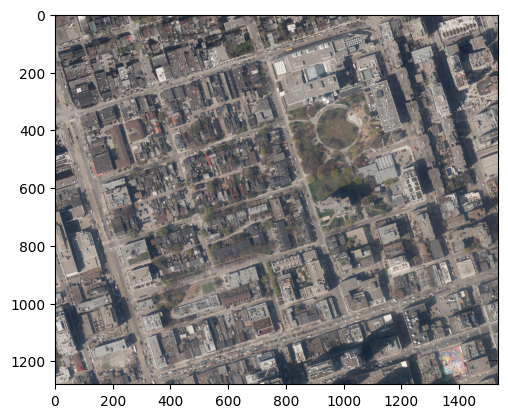

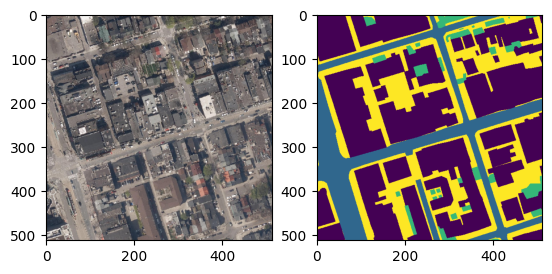

In [46]:
# Visualize full image
rasterio.plot.show(full_image)

# Visualize lablled aerial and classes
fig, ax = plt.subplots(1,2)
ax[0].imshow(reshape_as_image(labels_aerial))
ax[1].imshow(labels_classes)

## Data Preparation

### Split Label Image into Patches

In [5]:
# Define patch size and step
patch_size = 128
patch_step = 32#patch_size // 2

In [6]:
from patchify import patchify

# Patchify
patches_classes = patchify(labels_classes, (patch_size, patch_size), step=patch_step) # shape (num_patches, 3, patch_size, patch_size)
patches_aerial = patchify(labels_aerial, (3, patch_size, patch_size), step=patch_step)[0] # shape (num_patches, patch_size, patch_size)

# Reshape patches into one list
X = patches_aerial.reshape(-1, 3, patch_size, patch_size) 
print(X.shape)
X = np.transpose(X, (0, 2, 3, 1)) 
print(X.shape)

Y = patches_classes.reshape(-1, patch_size, patch_size)

num_patches = X.shape[0]

print(f"Split into {num_patches} patches of size {patch_size} x {patch_size}, with step {patch_step}")
print(f"X (input) shape: {X.shape}")  # (num_patches, 3, 128, 128)
print(f"Y (labels) shape: {Y.shape}")  # (num_patches, 128, 128)

(169, 3, 128, 128)
(169, 128, 128, 3)
Split into 169 patches of size 128 x 128, with step 32
X (input) shape: (169, 128, 128, 3)
Y (labels) shape: (169, 128, 128)


#### ***Optional:*** *Visualize patches*

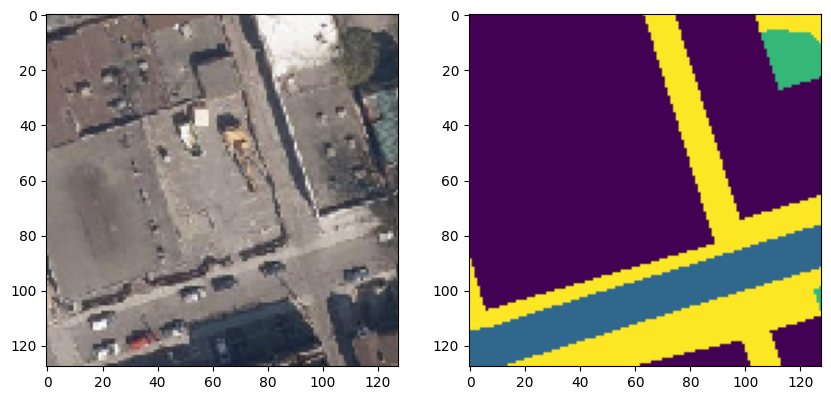

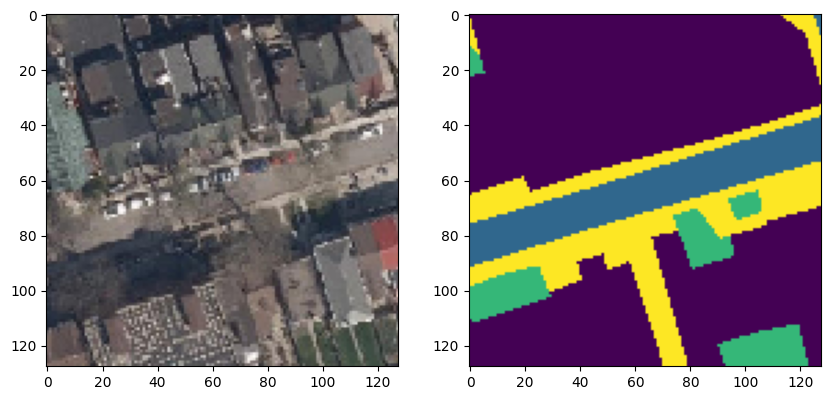

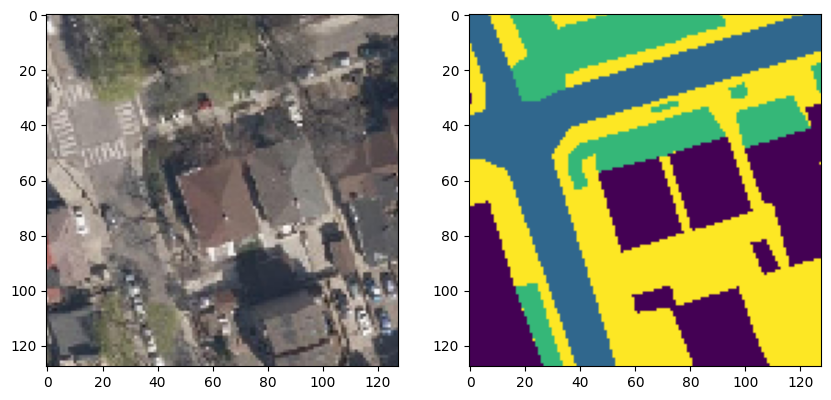

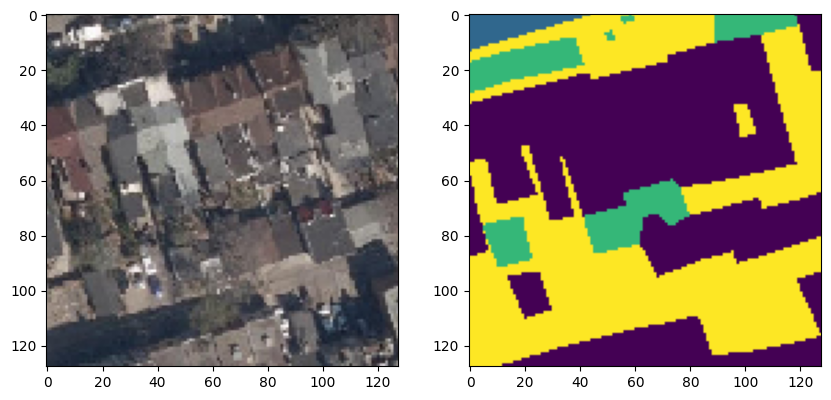

In [8]:
patches_to_show = 4 # How many patches to show (<20 recommended)
shown = 0

# Visulaize aerial raster and class raster patches next to each other
while shown < min(patches_to_show, num_patches):    
    fig, ax = plt.subplots(1, 2, figsize=(10,10))

    ax[0].imshow(X[shown])
    ax[1].imshow(Y[shown])

    shown += 1

## Data Processing
### Convert Class Labels to Categorical

In [9]:
# 0 building, 1 road, 2 vegetation, 3 alley/sidewalk/pavement

In [7]:
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(Y))

# Y classes are 1-indexed, need them 0-indexed
Y_shifted = Y - 1
# One hot encode the labels
Y_one_hot = to_categorical(Y_shifted, num_classes=num_classes)
print(f"Y (one-hot) shape: {Y_one_hot.shape}") 

Y (one-hot) shape: (169, 128, 128, 4)


### Split Training and Testing Data

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=RNG_SEED)
print(f"Train set - X: {X_train.shape}, Y: {Y_train.shape}")
print(f"Test set -  X: {X_test.shape}, Y: {Y_test.shape}")

Train set - X: (135, 128, 128, 3), Y: (135, 128, 128, 4)
Test set -  X: (34, 128, 128, 3), Y: (34, 128, 128, 4)


## Build CNN Model


In [9]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),  # Upsample back

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(4, (1,1), activation='softmax')  # Output 4 classes per pixel
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

C:\Users\Connor\Documents\Code\QGIS\to-lulc-aiml\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 4)         │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,365,924 (5.21 MB)

 Trainable params: 1,365,924 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=10, validation_data=(X_test, Y_test))

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.4215 - loss: 1.2348 - val_accuracy: 0.5164 - val_loss: 1.1349
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5261 - loss: 1.1236 - val_accuracy: 0.5164 - val_loss: 1.1254
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5261 - loss: 1.1020 - val_accuracy: 0.5164 - val_loss: 1.1288
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5261 - loss: 1.0952 - val_accuracy: 0.5164 - val_loss: 1.1059
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5261 - loss: 1.0768 - val_accuracy: 0.5164 - val_loss: 1.0927
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5261 - loss: 1.0563 - val_accuracy: 0.5164 - val_loss: 1.0857
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5261 - loss: 1.0431 - val_accuracy: 0.5164 - val_loss: 1.0887
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5261 - loss: 1.0405 - val_accu

### Evaluate Accuracy

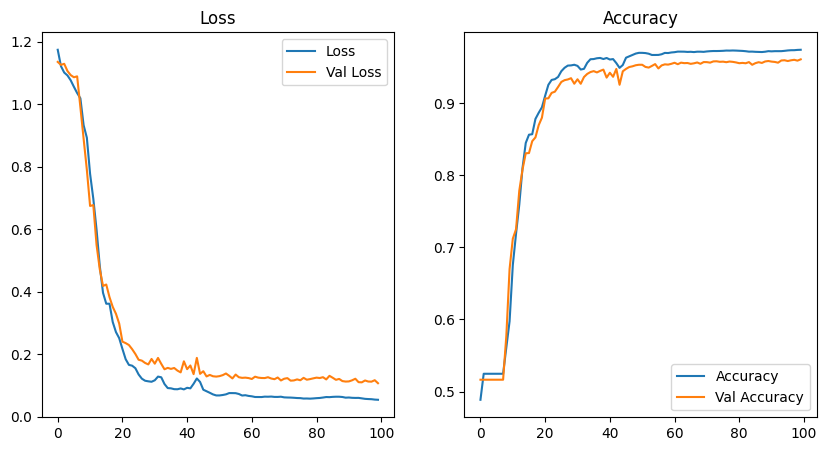

In [11]:
# Plot training loss & accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()

In [15]:
# Beep when done
beep = np.sin(2*np.pi*800*np.arange(3000*2)/10000)
Audio(beep, rate=6000, autoplay=True)

## Predict the Image

### Full Image Preprocessing

In [12]:
patch_full_step = 32

In [13]:
#rasterio.plot.show(full_image)#
from patchify import unpatchify

full_image_reshaped = reshape_as_image(full_image)
print("Full Image shape:", full_image_reshaped.shape)  # (2347, 2560, 3)

patches_full = patchify(full_image_reshaped, (patch_size, patch_size, 3), step=patch_full_step)
#patches_full = patches_full[0]
patches_full_x, patches_full_y = patches_full.shape[0:2]
print(patches_full_x, patches_full_y)
print("Patched Image shape:", patches_full.shape)  

patches_full_reshaped = patches_full.reshape(-1, patch_size, patch_size, 3)
print("Reshaped for Model shape:", patches_full_reshaped.shape)  

Full Image shape: (1280, 1536, 3)
37 45
Patched Image shape: (37, 45, 1, 128, 128, 3)
Reshaped for Model shape: (1665, 128, 128, 3)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step
Predictions shape: (1665, 128, 128, 4)
Reshaped Predictions shape: (37, 45, 128, 128, 4)
Predicted Classes shape: (37, 45, 128, 128)
Blended Full Prediction shape: (1312, 1568)


C:\Users\Connor\AppData\Local\Temp\ipykernel_41268\1343241321.py:37: RuntimeWarning: invalid value encountered in divide
  full_prediction /= weight_matrix
C:\Users\Connor\AppData\Local\Temp\ipykernel_41268\1343241321.py:38: RuntimeWarning: invalid value encountered in cast
  full_prediction = full_prediction.astype(np.uint8)


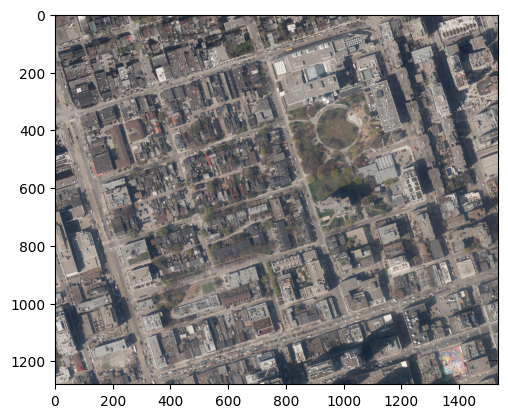

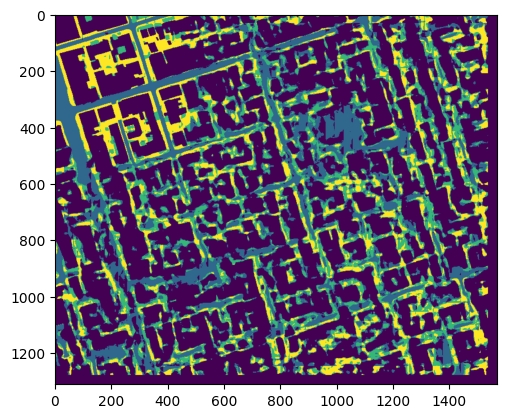

<Axes: >

In [14]:
predictions = model.predict(patches_full_reshaped)
print("Predictions shape:", predictions.shape) 
#print(predictions[0][:][:][:])

predictions = predictions.reshape(patches_full.shape[0], patches_full.shape[1], patch_size, patch_size, -1)
print("Reshaped Predictions shape:", predictions.shape)
#print(predictions[0][0][0][:][:])

predicted_classes = np.argmax(predictions, axis=-1)
print("Predicted Classes shape:", predicted_classes.shape)
#print(predicted_classes[0][0][:][:])

## UNPATCHIFY IMPLEMENTATION
## Does not handle step size other than the image size
#full_prediction = unpatchify(predicted_classes, (patches_full_x*patch_size, patches_full_y*patch_size))
#print("Full Prediction shape:", full_prediction.shape)

## BLENDING MATRIX IMPLEMENTATION
## Should weight overlapping areas by frequency of predicted class
# Initialize accumulation and weight matrices
full_prediction = np.zeros((patches_full_x * patch_full_step + patch_size, 
                            patches_full_y * patch_full_step + patch_size), dtype=np.float32)
weight_matrix = np.zeros_like(full_prediction, dtype=np.float32)

# Blend patches
for i in range(patches_full_x):
    for j in range(patches_full_y):
        x_start = i * patch_full_step
        x_end = x_start + patch_size
        y_start = j * patch_full_step
        y_end = y_start + patch_size
        
        full_prediction[x_start:x_end, y_start:y_end] += predicted_classes[i, j]
        weight_matrix[x_start:x_end, y_start:y_end] += 1  # Track contributions

# Normalize by the number of times each pixel was predicted
full_prediction /= weight_matrix
full_prediction = full_prediction.astype(np.uint8)
print("Blended Full Prediction shape:", full_prediction.shape)


rasterio.plot.show(full_image)
rasterio.plot.show(full_prediction)

In [16]:
# Beep when done
beep = np.sin(2*np.pi*800*np.arange(3000*2)/10000)
Audio(beep, rate=6000, autoplay=True)